# Perceptron Algorithm
This is one of the earliest learning algorithms

In [1]:
%matplotlib notebook
%qtconsole
import numpy as np
from matplotlib import pyplot as plt

# Get data (old school way)
We will download the orginal MNIST files from http://yann.lecun.com/exdb/mnist/
You can do this in your browser, but we can use command line utilities such as wget.
We will write a function to read the data files and parse the data into numpy arrays.
The data format used in this files (idx) in explained in the site above.

In [2]:
import urllib as ulib 
import os
import gzip
import sys

def readIDXFile(fileobject):
    f = fileobject
    if sys.byteorder == 'little': # check endiannes to read header
        byteorder = '>'
    else:
        byteorder = '<'

    f.seek(0)
    magic_number = np.frombuffer(f.read(4), dtype=np.byte, count=4)
    assert magic_number[0] == 0 and magic_number[1] == 0 , 'Magic number first two bytes are diffrent from zero' 
    data_type = {8: np.uint8,   #unsigned byte
                 9: np.int8,    #signed byte 
                 11: np.int16,   #short (2 bytes) 
                 12: np.int32,   #int (4 bytes)
                 13: np.float32, #float (4 bytes)
                 14: np.float64  #double (8 bytes) 
                }
    n_dim = magic_number[3]
    shape = np.frombuffer(f.read(n_dim * 4), dtype=np.dtype(np.uint32).newbyteorder(byteorder), count=n_dim)
    print('data shape :', shape)
    data = np.frombuffer(f.read(shape.prod() * 4), 
                         dtype=np.dtype(data_type[magic_number[2]]).newbyteorder(byteorder), 
                         count=shape.prod()).reshape(shape)
    return data

def getMNIST(destination='./data'):
    # URLs of the train and test data and labels
    data_urls = {'train_data' : 'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
                 'train_labels' : 'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
                 'test_data' : 'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
                 'test_labels' : 'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'}
    # check if destination directory exists, otherwise create it
    if os.path.isdir(destination) == False:
        print ('destination directory does not exist.\n A new directory %s will be created'%destination)
        os.mkdir(destination)
    # download fiels from mnist site
    data = {}
    for url_key in data_urls.keys():
        print('Downloading %s'%url_key)
        filename = os.path.split(data_urls[url_key])[-1]
        fullfilename = os.path.join(destination, filename)
        if os.path.isfile(fullfilename) == False:
            downfilename, headers = ulib.urlretrieve(data_urls[url_key], filename=fullfilename)
        print('Uncompressing %s'%url_key)
        with gzip.GzipFile(fullfilename, mode='rb') as f:
            data[url_key] = readIDXFile(f)
    return data
        

Uncompressing train_labels
('data shape :', array([60000], dtype=uint32))
Uncompressing test_labels
('data shape :', array([10000], dtype=uint32))
Uncompressing test_data
('data shape :', array([10000,    28,    28], dtype=uint32))
Uncompressing train_data
('data shape :', array([60000,    28,    28], dtype=uint32))


<IPython.core.display.Javascript object>


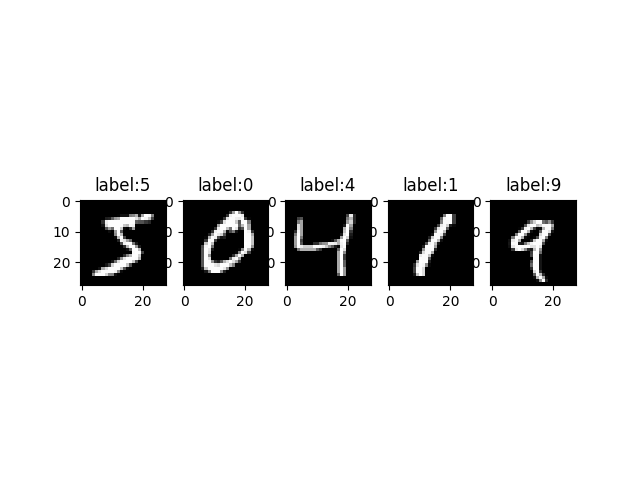

In [3]:
# read the files into numpy arrays
all_data = getMNIST()
## We can take a look at a few images
train_data = all_data['train_data']
train_labels = all_data['train_labels']
# show the first 5 examples from the data set
n_digits = 5
for i in range(n_digits):
    plt.subplot(1, n_digits, i+1)
    plt.imshow(train_data[i, :, :], cmap='gray')
    plt.title('label:%d'%train_labels[i])
    


# Binary classification problem

<IPython.core.display.Javascript object>


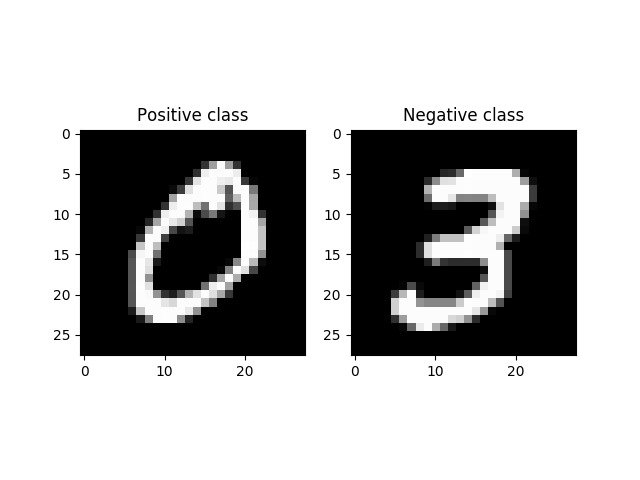

Text(0.5,1,'Negative class')

In [4]:
# choose the digits we want to classify
pos_class = 0
neg_class = 3

# get samples from positive and negative classes 
pos_data = train_data[train_labels == pos_class]  
neg_data = train_data[train_labels == neg_class]

# Look at some digits from the classes
# Look at different samples from each class (here plotted just the first)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(pos_data[0], cmap='gray')
plt.title('Positive class')
plt.subplot(1,2,2)
plt.imshow(neg_data[0], cmap='gray')
plt.title('Negative class')



In [5]:
# Gather the samples from the two classes into one matrix X
X = np.concatenate((pos_data, neg_data), axis=0)

# Label the two classes with 1 and -1 respectively
Y = np.concatenate((np.ones(pos_data.shape[0]), -np.ones(neg_data.shape[0])), axis=0)

# Choose random samples from data. To do so:
# permute data samples to run the learning  algorithm 
# and take just n_samples from the permuted data (here 60 samples)
n_samples = 60  
p_idx = np.random.choice(X.shape[0], n_samples)
X = X[p_idx]
Y = Y[p_idx]


# Let's come up with some features
Here, we woudl like to give simple ideas of how you could hadcraft some informative features about your data.


<IPython.core.display.Javascript object>


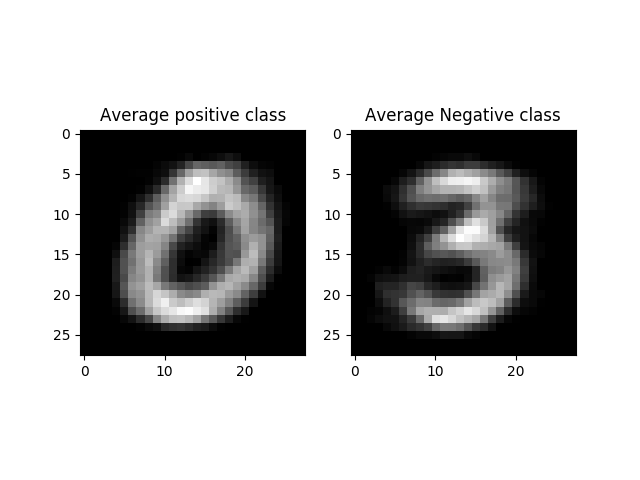

Text(0.5,1,'Average Negative class')

In [6]:
# Project the data onto the means of the two classes
# First look at the mean of the two class
plt.figure()
plt.subplot(1,2,1)
plt.imshow(np.mean(X[Y == 1], axis=0), cmap='gray')
plt.title('Average positive class')
# mean of second class
plt.subplot(1,2,2)
plt.imshow(np.mean(X[Y == -1], axis=0), cmap='gray')
plt.title('Average Negative class')



<IPython.core.display.Javascript object>


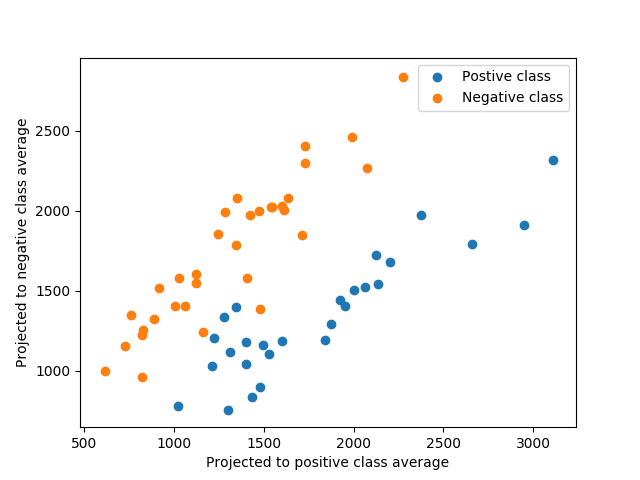

Text(0,0.5,'Projected to negative class average')

In [7]:
# Now project the data
# We are going to flatten the images into vectors
X = X.reshape((X.shape[0], -1))
V = np.zeros((2, X.shape[-1]), dtype=X.dtype)    
V[0, :] = np.mean(X[Y == 1], axis=0)
V[1, :] = np.mean(X[Y == -1], axis=0)
V = V / np.linalg.norm(V, axis=1, keepdims=True)
# Project data onto mean vectors for class 1 and class -1
Z = np.dot(X, V.transpose())
# Let's look at the values of these projections
plt.figure()
plt.scatter(Z[Y == 1, 0], Z[Y == 1, 1], )
plt.scatter(Z[Y == -1, 0], Z[Y == -1, 1], )
plt.legend(['Postive class', 'Negative class'])
plt.xlabel('Projected to positive class average')
plt.ylabel('Projected to negative class average')

# Simple learning algorithm for the perceptron
Here, we denote two classes: the positive class by label $1$  and the negative class by label $-1$. 
Any point in the plane colored as green will be classified as positive class and any point falling within the red region as negative class. Training samples are denoted by the green crosses (positive) and red dots (negative). A missclassified training point, that is $f_i \neq y_i$ is marked with a circle 


In [8]:
# A little plotting function
def display2DPartition(X, Y, w, b, ax, fig):
    ''' displayPartition
    Inputs:
     -- X : 2-dimensional array of size N x 2, where N is the number of data 
        samples.
     -- Y : vector of length N containing the data labels
     -- w : vector of length 2 representing the decision hyperplane. this vector
            is actually normal to the decision hyperplane.
     -- b : bias parameter of the decision hyperplane.
     -- h : (Optional) figure handle to plot. If not provided, a new figure
            handle will be created and provided as output
     Outputs:
     -- h : figure handle for the display
    '''
    # compute ranges of the display based on the data
    x_lim = [X.min(axis=0), X.max(axis=0)]
    x_range = x_lim[1] - x_lim[0]
    x_lim[0] -= x_range/6
    x_lim[1] += x_range/6
            
    # create image of partition
    n_points = 100
    x1_grid = np.linspace(x_lim[0][0], x_lim[1][0], n_points)
    x2_grid = np.linspace(x_lim[0][1], x_lim[1][1], n_points)
    
    X1_grid, X2_grid = np.meshgrid(x1_grid, x2_grid)

    X_grid = np.concatenate((X1_grid.flatten()[:,None], X2_grid.flatten()[:,None]), axis=1)
    Y_grid = np.sign(np.dot(X_grid, w) + b)
    Y_grid = np.reshape(Y_grid, X1_grid.shape)
    IM_grid = np.ones(Y_grid.shape + (3, )) * 204
    IM_grid[:, :, 0] = np.double(Y_grid == -1) * 41 + 204
    IM_grid[:, :, 1] = np.double(Y_grid >= 0) * 41 + 204
    ax.clear()
    ax.imshow(IM_grid[-1:1:-1, :, :]/255, extent=(x_lim[0][0], x_lim[1][0], x_lim[0][1],x_lim[1][1]))
    # plot data points
    ax.plot(X[Y==-1, 0], X[Y==-1, 1], 'r.')
    ax.plot(X[Y==1, 0], X[Y==1, 1], 'g+')
    
    # circle misclassified points
    Y_pred = np.sign(np.dot(X, w) + b);
    ax.plot(X[np.logical_and(Y_pred == -1, Y == 1), 0], X[np.logical_and(Y_pred == -1, Y == 1), 1], 'go')
    ax.plot(X[np.logical_and(Y_pred == 1, Y == -1), 0], X[np.logical_and(Y_pred == 1, Y == -1), 1], 'ro')  
    # disable hold gca
    fig.canvas.draw()

<IPython.core.display.Javascript object>


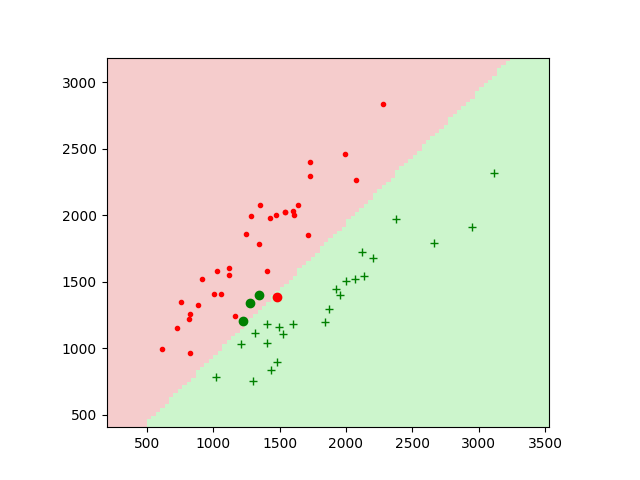

In [16]:
lr = 1 # Learning rate parameter (1 in the classical perceptron algorithm)
w = np.random.normal(size=(Z.shape[-1], )) # Initial guess for the hyperplane parameters
b = 0.0                    # bias is initially zero
max_epoch = 100          # Number of epoch (complete loops trough all data)
epoch = 0                # epoch counter
fig,ax = plt.subplots(1,1)
plt.ion()
while epoch < max_epoch:
    # loop trough all data points one time (an epoch)
    for iSmp in range(n_samples):
        z_i = Z[iSmp, :] 
        # compute prediction with current w and b
        f_i = np.sign(np.dot(w, z_i) + b)
        # update w and b if missclassified
        if f_i != Y[iSmp]:
            w = w + lr * Y[iSmp] * z_i
            b = b + lr * Y[iSmp]
    # display current decision hyperplane (partition of the space)
    display2DPartition(Z, Y, w, b, ax, fig)
    plt.draw()
    plt.pause(0.1)
    epoch += 1
    



# EXERCISE: After trying the code for the given classes,
Try running the code again, but this time changing the digits of the positive or negative class. 
You can do this by changing the following two lines above: 
pos_class = 0 
neg_class = 5
What classes are easier to learn?

In [ ]:
## YOUR CODE HERE

# Linear classification using softmax
In this exercise, we implemneted the kNN classifier to gain intuition about classification problem and create a baseline.
For linear classification, we will use the functions available in scikit-learn library

[[8.47072428e-01 1.52927572e-01]
 [4.53613005e-04 9.99546387e-01]
 [9.99665063e-01 3.34936873e-04]
 [9.97793681e-01 2.20631908e-03]
 [1.80014198e-04 9.99819986e-01]
 [9.96321374e-01 3.67862596e-03]]
[[-1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]]


<IPython.core.display.Javascript object>


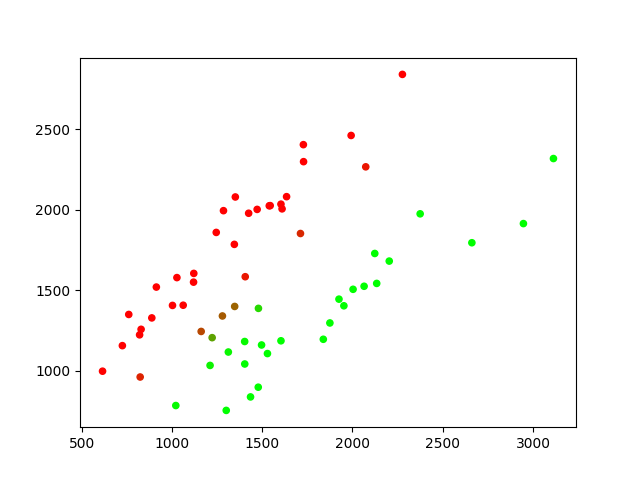

In [15]:
from sklearn.linear_model import LogisticRegression

mySoftmax = LogisticRegression()
mySoftmax.fit(Z, Y)
Y_test = mySoftmax.predict(Z)
P_test = mySoftmax.predict_proba(Z)

print (P_test[::10])
print (Y_test[::10, None])
P_colors = np.concatenate((P_test, np.zeros((P_test.shape[0],1), dtype=P_test.dtype)), axis=1)
plt.figure()
plt.scatter(Z[:,0], Z[:, 1], s=20, c=P_colors)
plt.show()